In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!pip install -q torch torchvision scikit-learn pillow matplotlib tqdm seaborn

In [13]:
import os, random, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34
from torchvision.transforms import InterpolationMode
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
)


In [14]:
ROOT_DIR = "/content/drive/MyDrive/pp_7030"
OUT_DIR  = "/content/drive/MyDrive/stroke_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

BATCH_SIZE = 4  # Reduced for Colab free
LR = 1e-4
EPOCHS = 40
IMG_SIZE = 256  # Slightly larger for better segmentation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_PATH = os.path.join(OUT_DIR, "best_stroke_model.pth")
print(f"✅ Using device: {DEVICE}")


✅ Using device: cuda


In [15]:
# =====================================================
# 🧱 Dataset Loader (FIXED)
# =====================================================
class StrokeDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.mask_transform = mask_transform

        stroke_base = os.path.join(root_dir, split, "stroke")
        img_dir = os.path.join(stroke_base, "png")
        mask_dir = os.path.join(stroke_base, "mask")

        self.stroke_imgs = sorted(glob(os.path.join(img_dir, "*.png")))
        self.stroke_masks = sorted(glob(os.path.join(mask_dir, "*.png")))
        normal_dir = os.path.join(root_dir, split, "normal")
        self.normal_imgs = sorted(glob(os.path.join(normal_dir, "*.png")))

        name = lambda p: os.path.splitext(os.path.basename(p))[0]
        mask_map = {name(m): m for m in self.stroke_masks}

        self.samples = []
        for im in self.stroke_imgs:
            n = name(im)
            if n in mask_map:
                self.samples.append((im, mask_map[n], 1))
        for im in self.normal_imgs:
            self.samples.append((im, None, 0))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")

        if mask_path:
            mask = Image.open(mask_path).convert("L")
        else:
            mask = Image.new("L", img.size, 0)

        if self.transform:
            img = self.transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return img, mask, torch.tensor(label, dtype=torch.long)

In [16]:
# =====================================================
# 🎨 Transforms
# =====================================================
transform_img = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
transform_mask = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

train_ds = StrokeDataset(ROOT_DIR, "train", transform_img, transform_mask)
val_ds   = StrokeDataset(ROOT_DIR, "test",  transform_img, transform_mask)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")

Train: 2323 | Val: 937


In [17]:
# =====================================================
# 🧮 Loss Functions (FIXED)
# =====================================================
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)  # Apply sigmoid first
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        inter = (inputs * targets).sum(1)
        union = inputs.sum(1) + targets.sum(1)
        dice = (2.*inter + self.smooth) / (union + self.smooth)
        return 1. - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        focal = self.alpha * (1-pt)**self.gamma * bce
        return focal.mean()

In [18]:
# =====================================================
# 🧩 FIXED U-Net Style Model with ResNet Encoder
# =====================================================
class StrokeUNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # Encoder: ResNet34 backbone
        resnet = resnet34(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1  # 64 channels
        self.layer2 = resnet.layer2  # 128 channels
        self.layer3 = resnet.layer3  # 256 channels
        self.layer4 = resnet.layer4  # 512 channels

        # Classification head
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # Decoder with skip connections
        self.up1 = self._up_block(512, 256)
        self.up2 = self._up_block(256 + 256, 128)  # +256 from skip
        self.up3 = self._up_block(128 + 128, 64)   # +128 from skip
        self.up4 = self._up_block(64 + 64, 32)     # +64 from skip

        # Final segmentation output
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, 2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, 1)
        )

    def _up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 2, 2),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, 1, 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        x0 = self.relu(self.bn1(self.conv1(x)))  # 128x128
        x_pool = self.maxpool(x0)                # 64x64

        x1 = self.layer1(x_pool)   # 64x64, 64 ch
        x2 = self.layer2(x1)       # 32x32, 128 ch
        x3 = self.layer3(x2)       # 16x16, 256 ch
        x4 = self.layer4(x3)       # 8x8, 512 ch

        # Classification
        pooled = self.global_pool(x4).view(x4.size(0), -1)
        logits = self.classifier(pooled)

        # Decoder with skip connections
        d1 = self.up1(x4)                      # 16x16, 256 ch
        d1 = torch.cat([d1, x3], dim=1)        # Concat with x3

        d2 = self.up2(d1)                      # 32x32, 128 ch
        d2 = torch.cat([d2, x2], dim=1)        # Concat with x2

        d3 = self.up3(d2)                      # 64x64, 64 ch
        d3 = torch.cat([d3, x1], dim=1)        # Concat with x1

        d4 = self.up4(d3)                      # 128x128, 32 ch

        seg = self.final_up(d4)                # 256x256, 1 ch

        return logits, seg

In [19]:
# =====================================================
# 🔁 Training Setup (FIXED)
# =====================================================
criterion_cls = nn.CrossEntropyLoss()
criterion_seg_bce = nn.BCEWithLogitsLoss()
criterion_seg_dice = DiceLoss()
criterion_seg_focal = FocalLoss()

model = StrokeUNet(num_classes=2).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

def compute_loss(logits, seg, labels, masks):
    """FIXED: Only compute segmentation loss for stroke samples"""
    loss_cls = criterion_cls(logits, labels)

    # Only compute seg loss for stroke samples (label==1)
    stroke_mask = (labels == 1)
    if stroke_mask.sum() > 0:
        seg_stroke = seg[stroke_mask]
        masks_stroke = masks[stroke_mask]

        loss_bce = criterion_seg_bce(seg_stroke, masks_stroke)
        loss_dice = criterion_seg_dice(seg_stroke, masks_stroke)
        loss_focal = criterion_seg_focal(seg_stroke, masks_stroke)
        loss_seg = loss_bce + loss_dice + 0.5 * loss_focal
    else:
        loss_seg = torch.tensor(0.0).to(DEVICE)

    # Balanced weighting
    total = loss_cls + 2.0 * loss_seg
    return total, loss_cls, loss_seg

In [20]:
# =====================================================
# 🚀 Training + Validation (FIXED)
# =====================================================
def train_one_epoch(model, loader):
    model.train()
    total_loss, total_cls, total_seg = 0, 0, 0
    correct, total = 0, 0
    all_labels, all_probs = [], []

    for imgs, masks, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits, seg = model(imgs)
        loss, loss_cls, loss_seg = compute_loss(logits, seg, labels, masks)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        total_cls += loss_cls.item()
        total_seg += loss_seg.item() if isinstance(loss_seg, torch.Tensor) else 0

        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(F.softmax(logits, dim=1)[:,1].detach().cpu().numpy())

    acc = correct / total
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    return total_loss/len(loader), total_cls/len(loader), total_seg/len(loader), acc, auc

def validate(model, loader):
    model.eval()
    total_loss, total_cls, total_seg = 0, 0, 0
    correct, total = 0, 0
    all_labels, all_probs, all_preds = [], [], []

    with torch.no_grad():
        for imgs, masks, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            labels = labels.to(DEVICE)

            logits, seg = model(imgs)
            loss, loss_cls, loss_seg = compute_loss(logits, seg, labels, masks)

            total_loss += loss.item()
            total_cls += loss_cls.item()
            total_seg += loss_seg.item() if isinstance(loss_seg, torch.Tensor) else 0

            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(F.softmax(logits, dim=1)[:,1].detach().cpu().numpy())

    acc = correct / total
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    return total_loss/len(loader), total_cls/len(loader), total_seg/len(loader), acc, auc, fpr, tpr, all_labels, all_preds



📘 Epoch 1/40


Train - Loss: 3.0490 (Cls: 0.3764, Seg: 1.3363) | Acc: 85.75% | AUC: 0.9261
Val   - Loss: 1.7784 (Cls: 0.2333, Seg: 0.7726) | Acc: 91.78% | AUC: 0.9710
✅ Saved best model (AUC=0.9710)

📘 Epoch 2/40


Train - Loss: 2.3138 (Cls: 0.2213, Seg: 1.0462) | Acc: 94.49% | AUC: 0.9736
Val   - Loss: 1.4279 (Cls: 0.2795, Seg: 0.5742) | Acc: 91.57% | AUC: 0.9822
✅ Saved best model (AUC=0.9822)

📘 Epoch 3/40


Train - Loss: 1.7848 (Cls: 0.0803, Seg: 0.8523) | Acc: 98.28% | AUC: 0.9929
Val   - Loss: 1.4069 (Cls: 0.3013, Seg: 0.5528) | Acc: 90.39% | AUC: 0.9849
✅ Saved best model (AUC=0.9849)

📘 Epoch 4/40


Train - Loss: 1.4656 (Cls: 0.0987, Seg: 0.6835) | Acc: 98.02% | AUC: 0.9926
Val   - Loss: 1.4904 (Cls: 0.4882, Seg: 0.5011) | Acc: 89.97% | AUC: 0.9720

📘 Epoch 5/40


Train - Loss: 1.1884 (Cls: 0.0769, Seg: 0.5558) | Acc: 98.62% | AUC: 0.9931
Val   - Loss: 1.2652 (Cls: 0.5120, Seg: 0.3766) | Acc: 91.14% | AUC: 0.9756

📘 Epoch 6/40


Train - Loss: 0.9524 (Cls: 0.0519, Seg: 0.4503) | Acc: 98.36% | AUC: 0.9984
Val   - Loss: 1.1814 (Cls: 0.4508, Seg: 0.3653) | Acc: 91.36% | AUC: 0.9770

📘 Epoch 7/40


Train - Loss: 0.7487 (Cls: 0.0260, Seg: 0.3613) | Acc: 99.53% | AUC: 0.9991
Val   - Loss: 1.0895 (Cls: 0.3658, Seg: 0.3618) | Acc: 92.64% | AUC: 0.9855
✅ Saved best model (AUC=0.9855)

📘 Epoch 8/40


Train - Loss: 0.5970 (Cls: 0.0099, Seg: 0.2936) | Acc: 99.78% | AUC: 0.9999
Val   - Loss: 1.1557 (Cls: 0.4270, Seg: 0.3644) | Acc: 92.32% | AUC: 0.9832

📘 Epoch 9/40


Train - Loss: 0.4959 (Cls: 0.0006, Seg: 0.2477) | Acc: 99.96% | AUC: 1.0000
Val   - Loss: 1.1077 (Cls: 0.3709, Seg: 0.3684) | Acc: 92.74% | AUC: 0.9915
✅ Saved best model (AUC=0.9915)

📘 Epoch 10/40


Train - Loss: 0.3988 (Cls: 0.0026, Seg: 0.1981) | Acc: 99.96% | AUC: 1.0000
Val   - Loss: 1.2603 (Cls: 0.5581, Seg: 0.3511) | Acc: 93.49% | AUC: 0.9857

📘 Epoch 11/40


Train - Loss: 0.3469 (Cls: 0.0017, Seg: 0.1726) | Acc: 99.96% | AUC: 1.0000
Val   - Loss: 1.1474 (Cls: 0.5128, Seg: 0.3173) | Acc: 91.46% | AUC: 0.9804

📘 Epoch 12/40


Train - Loss: 0.3118 (Cls: 0.0012, Seg: 0.1553) | Acc: 99.96% | AUC: 1.0000
Val   - Loss: 0.9586 (Cls: 0.3336, Seg: 0.3125) | Acc: 92.96% | AUC: 0.9890

📘 Epoch 13/40


Train - Loss: 0.2726 (Cls: 0.0000, Seg: 0.1363) | Acc: 100.00% | AUC: 1.0000
Val   - Loss: 1.1715 (Cls: 0.5270, Seg: 0.3222) | Acc: 91.46% | AUC: 0.9874

📘 Epoch 14/40


Train - Loss: 0.2528 (Cls: 0.0054, Seg: 0.1237) | Acc: 99.91% | AUC: 1.0000
Val   - Loss: 1.8066 (Cls: 1.0364, Seg: 0.3851) | Acc: 88.79% | AUC: 0.9864

📘 Epoch 15/40


Train - Loss: 0.2247 (Cls: 0.0001, Seg: 0.1123) | Acc: 100.00% | AUC: 1.0000
Val   - Loss: 1.0542 (Cls: 0.3434, Seg: 0.3554) | Acc: 94.02% | AUC: 0.9882

📘 Epoch 16/40


Train - Loss: 0.2053 (Cls: 0.0003, Seg: 0.1025) | Acc: 99.96% | AUC: 1.0000
Val   - Loss: 1.0373 (Cls: 0.3540, Seg: 0.3417) | Acc: 93.60% | AUC: 0.9883

📘 Epoch 17/40


Train - Loss: 0.1937 (Cls: 0.0000, Seg: 0.0969) | Acc: 100.00% | AUC: 1.0000
Val   - Loss: 0.9849 (Cls: 0.2521, Seg: 0.3664) | Acc: 94.45% | AUC: 0.9901

📘 Epoch 18/40


Train - Loss: 0.1793 (Cls: 0.0000, Seg: 0.0897) | Acc: 100.00% | AUC: 1.0000
Val   - Loss: 0.9878 (Cls: 0.3688, Seg: 0.3095) | Acc: 93.70% | AUC: 0.9885

📘 Epoch 19/40


Train - Loss: 0.1649 (Cls: 0.0000, Seg: 0.0824) | Acc: 100.00% | AUC: 1.0000
Val   - Loss: 0.9957 (Cls: 0.3094, Seg: 0.3431) | Acc: 94.24% | AUC: 0.9912
Early stopping at epoch 19


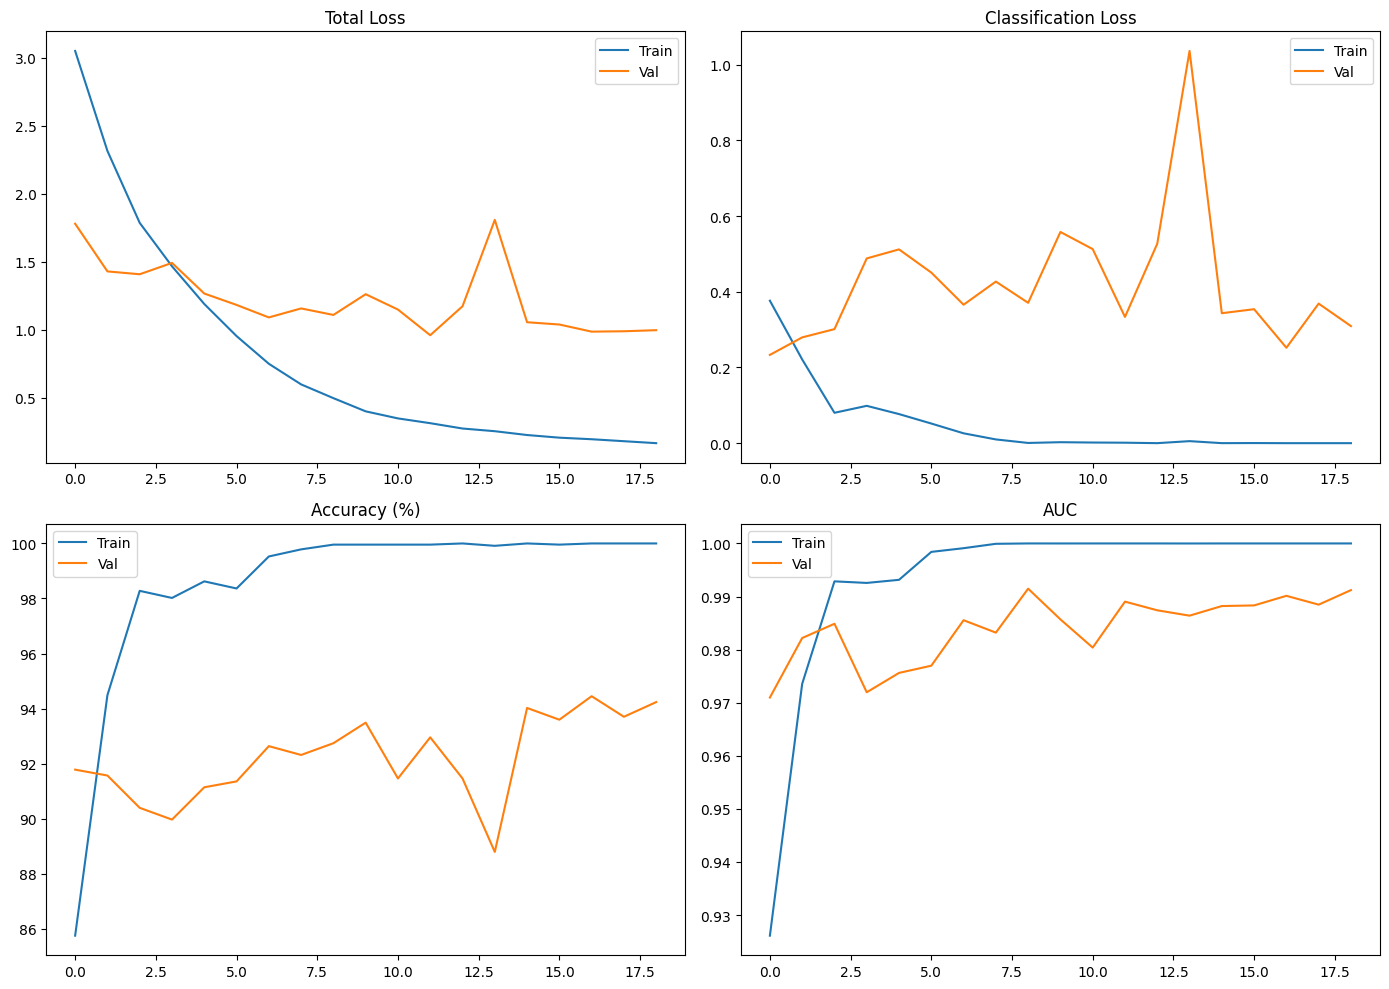

In [21]:
# =====================================================
# 📈 Training Loop
# =====================================================
history = {
    'train_loss':[], 'train_cls':[], 'train_seg':[], 'train_acc':[], 'train_auc':[],
    'val_loss':[], 'val_cls':[], 'val_seg':[], 'val_acc':[], 'val_auc':[]
}

best_auc = 0
patience = 10
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\n📘 Epoch {epoch+1}/{EPOCHS}")

    tr_loss, tr_cls, tr_seg, tr_acc, tr_auc = train_one_epoch(model, train_loader)
    val_loss, val_cls, val_seg, val_acc, val_auc, fpr, tpr, val_labels, val_preds = validate(model, val_loader)

    scheduler.step()

    print(f"Train - Loss: {tr_loss:.4f} (Cls: {tr_cls:.4f}, Seg: {tr_seg:.4f}) | Acc: {tr_acc*100:.2f}% | AUC: {tr_auc:.4f}")
    print(f"Val   - Loss: {val_loss:.4f} (Cls: {val_cls:.4f}, Seg: {val_seg:.4f}) | Acc: {val_acc*100:.2f}% | AUC: {val_auc:.4f}")

    history['train_loss'].append(tr_loss); history['train_cls'].append(tr_cls)
    history['train_seg'].append(tr_seg); history['train_acc'].append(tr_acc)
    history['train_auc'].append(tr_auc)
    history['val_loss'].append(val_loss); history['val_cls'].append(val_cls)
    history['val_seg'].append(val_seg); history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'auc': best_auc,
        }, SAVE_PATH)
        print(f"✅ Saved best model (AUC={best_auc:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0,0].plot(history['train_loss'], label='Train'); axes[0,0].plot(history['val_loss'], label='Val')
axes[0,0].set_title("Total Loss"); axes[0,0].legend()
axes[0,1].plot(history['train_cls'], label='Train'); axes[0,1].plot(history['val_cls'], label='Val')
axes[0,1].set_title("Classification Loss"); axes[0,1].legend()
axes[1,0].plot(np.array(history['train_acc'])*100, label='Train'); axes[1,0].plot(np.array(history['val_acc'])*100, label='Val')
axes[1,0].set_title("Accuracy (%)"); axes[1,0].legend()
axes[1,1].plot(history['train_auc'], label='Train'); axes[1,1].plot(history['val_auc'], label='Val')
axes[1,1].set_title("AUC"); axes[1,1].legend()
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, 'training_history.png')); plt.show()


Evaluating: 100%|██████████| 235/235 [00:08<00:00, 28.44it/s]


📊 Classification Report:
              precision    recall  f1-score   support

      Normal     0.9195    0.9390    0.9291       377
      Stroke     0.9583    0.9446    0.9514       560

    accuracy                         0.9424       937
   macro avg     0.9389    0.9418    0.9403       937
weighted avg     0.9427    0.9424    0.9425       937



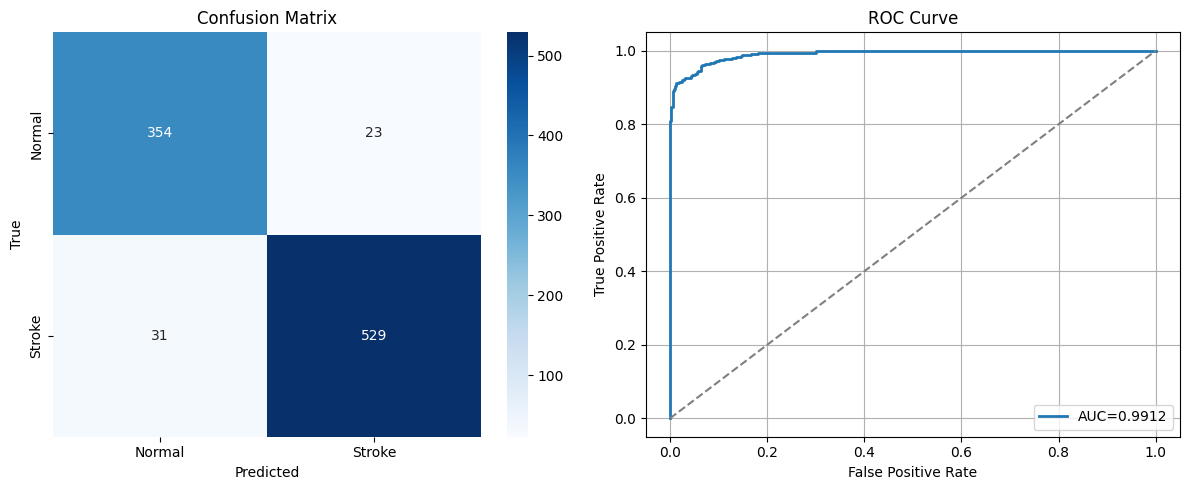

In [23]:
# =====================================================
# 🧾 Evaluation Metrics
# =====================================================
# Load best model
#checkpoint = torch.load(SAVE_PATH)
#model.load_state_dict(checkpoint['model_state_dict'])
#print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
#
def evaluate_model(model, loader):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for imgs, masks, labels in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            logits, seg = model(imgs)
            probs = F.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    auc_score = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)

    print("📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Normal','Stroke'], digits=4))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal','Stroke'], yticklabels=['Normal','Stroke'], ax=axes[0])
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True"); axes[0].set_title("Confusion Matrix")

    axes[1].plot(fpr, tpr, label=f"AUC={auc_score:.4f}", linewidth=2)
    axes[1].plot([0,1], [0,1], '--', color='gray')
    axes[1].set_xlabel("False Positive Rate"); axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title("ROC Curve"); axes[1].legend(); axes[1].grid(True)

    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, 'evaluation.png')); plt.show()

evaluate_model(model, val_loader)

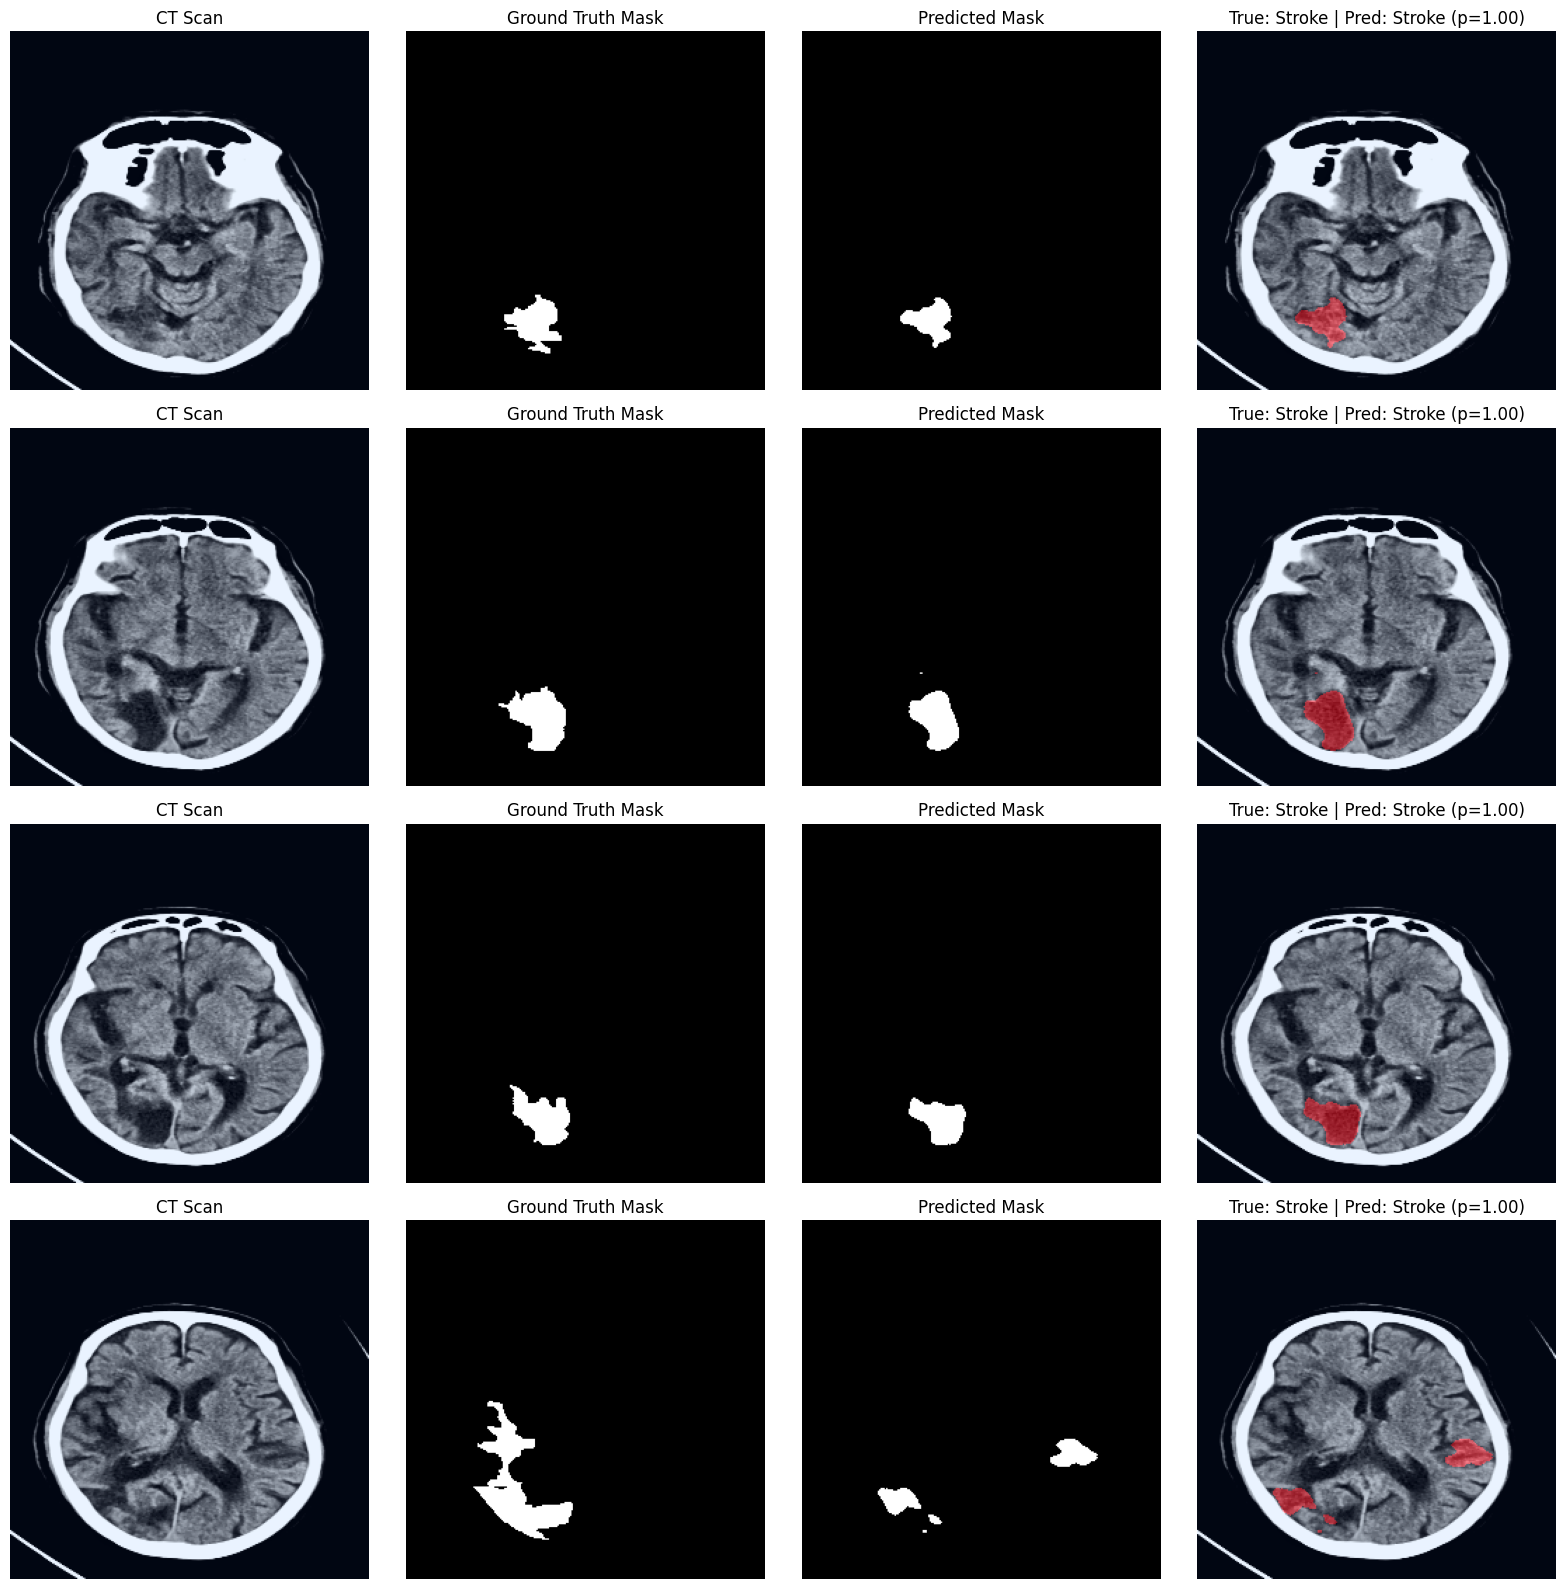

In [26]:
# =====================================================
# 🔍 Visualization (FIXED)
# =====================================================
def visualize_predictions(model, loader, num_images=8, threshold=0.5):
    model.eval()
    imgs, masks, labels = next(iter(loader))
    imgs = imgs.to(DEVICE)
    masks = masks.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        logits, segs = model(imgs)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(1)
        segs_np = torch.sigmoid(segs).cpu().numpy()

    n = min(num_images, imgs.size(0))
    fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for i in range(n):
        img = imgs[i].cpu().permute(1,2,0).numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        gt_mask = masks[i].cpu().squeeze().numpy()
        pred_mask = (segs_np[i,0] > threshold).astype(np.float32)

        overlay = img.copy()
        overlay[:,:,0] = np.clip(overlay[:,:,0] + pred_mask*0.5, 0, 1)

        axes[i,0].imshow(img); axes[i,0].axis('off'); axes[i,0].set_title("CT Scan")
        axes[i,1].imshow(gt_mask, cmap='gray'); axes[i,1].axis('off'); axes[i,1].set_title("Ground Truth Mask")
        axes[i,2].imshow(pred_mask, cmap='gray'); axes[i,2].axis('off'); axes[i,2].set_title(f"Predicted Mask")
        axes[i,3].imshow(overlay); axes[i,3].axis('off')
        true_label = 'Stroke' if labels[i]==1 else 'Normal'
        pred_label = 'Stroke' if preds[i]==1 else 'Normal'
        axes[i,3].set_title(f"True: {true_label} | Pred: {pred_label} (p={probs[i]:.2f})")

    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, 'predictions.png')); plt.show()

visualize_predictions(model, val_loader, num_images=8)